In [1]:
pip install opencv-python numpy scikit-image

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
from scipy.spatial.distance import euclidean

# Load & binarize image
img = cv2.imread(r"C:\Users\DWITI MAYUR BUDH\Downloads\j.jpg", 0)
_, bw = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)


labels = label(bw)
regions = regionprops(labels)


def desc(r):
    h = r.bbox[2] - r.bbox[0]
    w = r.bbox[3] - r.bbox[1]
    return np.array([h, w])

features = [desc(r) for r in regions]

THRESHOLD = 6   


groups = []
used = set()

for i, f1 in enumerate(features):
    if i in used: continue
    g = [i]; used.add(i)
    for j, f2 in enumerate(features):
        if j not in used and euclidean(f1, f2) < THRESHOLD:
            g.append(j); used.add(j)
    groups.append(g)


out = np.zeros_like(bw)
for g in groups:
    proto = regions[g[0]]
    for i in g:
        r = regions[i]
        out[r.bbox[0]:r.bbox[2], r.bbox[1]:r.bbox[3]] = \
            cv2.resize(
                bw[proto.bbox[0]:proto.bbox[2], proto.bbox[1]:proto.bbox[3]],
                (r.bbox[3]-r.bbox[1], r.bbox[2]-r.bbox[0]),
                cv2.INTER_NEAREST
            )

cv2.imshow("Result", out)

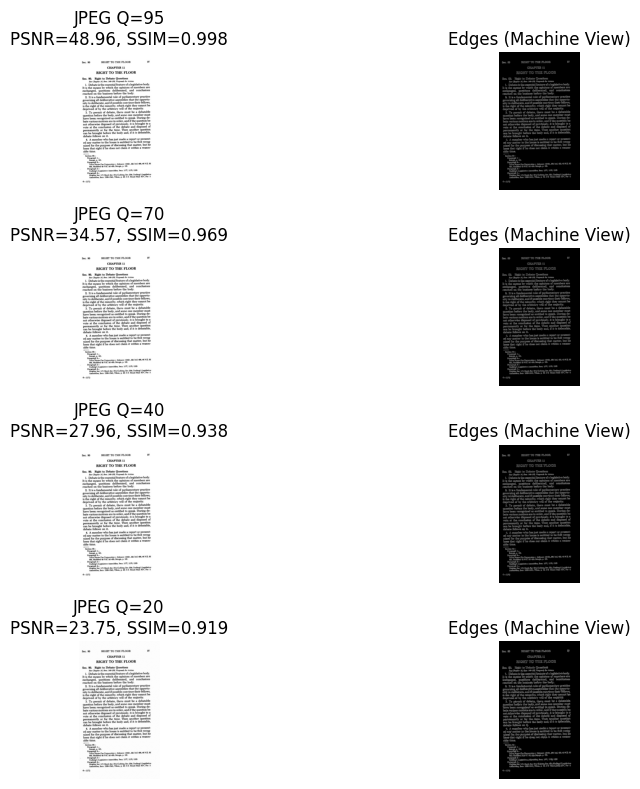

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

img = cv2.imread(r"C:\Users\DWITI MAYUR BUDH\Downloads\j.jpg", cv2.IMREAD_GRAYSCALE)
assert img is not None, "Image not found!"


qualities = [95, 70, 40, 20]

results = []


for q in qualities:
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), q]
    _, enc = cv2.imencode(".jpg", img, encode_param)
    comp = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)

    
    psnr = peak_signal_noise_ratio(img, comp, data_range=255)
    ssim = structural_similarity(img, comp, data_range=255)

    
    edges = cv2.Canny(comp, 100, 200)

    results.append((q, psnr, ssim, comp, edges))


plt.figure(figsize=(12, 8))

for i, (q, psnr, ssim, comp, edges) in enumerate(results):
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(comp, cmap='gray')
    plt.title(f"JPEG Q={q}\nPSNR={psnr:.2f}, SSIM={ssim:.3f}")
    plt.axis("off")

    plt.subplot(4, 2, 2*i+2)
    plt.imshow(edges, cmap='gray')
    plt.title("Edges (Machine View)")
    plt.axis("off")

plt.tight_layout()
plt.show()

Lossless components: 1
Lossy components: 1
SSIM Score: 1.0


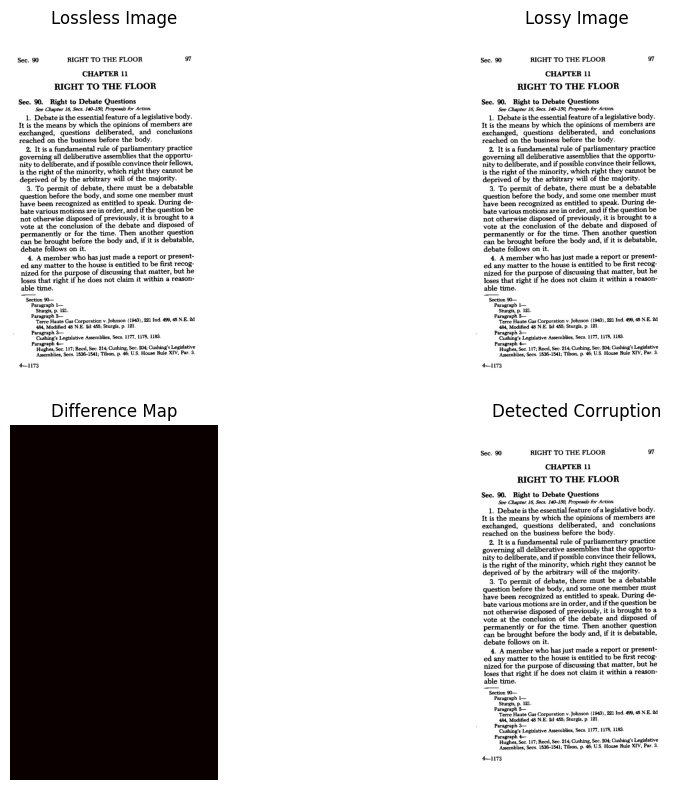

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

img_lossless = cv2.imread(r"C:\Users\DWITI MAYUR BUDH\Downloads\j.jpg", cv2.IMREAD_GRAYSCALE)
img_lossy = cv2.imread(r"C:\Users\DWITI MAYUR BUDH\Downloads\j.jpg", cv2.IMREAD_GRAYSCALE)

img_lossy = cv2.resize(img_lossy, (img_lossless.shape[1], img_lossless.shape[0]))

_, bin1 = cv2.threshold(img_lossless, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, bin2 = cv2.threshold(img_lossy, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

contours1, _ = cv2.findContours(bin1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(bin2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print("Lossless components:", len(contours1))
print("Lossy components:", len(contours2))

score, diff = ssim(img_lossless, img_lossy, full=True)
diff = (1 - diff) * 255
diff = diff.astype("uint8")

print("SSIM Score:", score)

_, diff_thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

diff_contours, _ = cv2.findContours(diff_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

output = cv2.cvtColor(img_lossless, cv2.COLOR_GRAY2BGR)

for cnt in diff_contours:
    if cv2.contourArea(cnt) > 50:  # ignore noise
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title("Lossless Image")
plt.imshow(img_lossless, cmap='gray')
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Lossy Image")
plt.imshow(img_lossy, cmap='gray')
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Difference Map")
plt.imshow(diff, cmap='hot')
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Detected Corruption")
plt.imshow(output)
plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
import cv2
import numpy as np
from skimage.measure import shannon_entropy

def extract_features(image_path):
    img = cv2.imread(r"C:\Users\DWITI MAYUR BUDH\Downloads\j.jpg", cv2.IMREAD_GRAYSCALE)

    # Resize for consistency
    img = cv2.resize(img, (800, 1000))

    # ---------- Entropy ----------
    entropy = shannon_entropy(img)

    # ---------- Edge Density ----------
    edges = cv2.Canny(img, 100, 200)
    edge_density = np.sum(edges > 0) / edges.size

    # ---------- Connected Components ----------
    _, binary = cv2.threshold(img, 0, 255,
                              cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    num_labels, _ = cv2.connectedComponents(binary)
    component_count = num_labels - 1  # remove background

    return entropy, edge_density, component_count

def safe_compression_rule(entropy, edge_density, components):

    # TEXT / FORMS → LOSSLESS
    if entropy < 4.5 and edge_density > 0.08 and components > 1000:
        return "LOSSLESS COMPRESSION"

    # PHOTOS → LOSSY
    elif entropy > 5.5 and edge_density < 0.05 and components < 500:
        return "LOSSY COMPRESSION"

    # CRITICAL / NOISY DOCUMENTS
    else:
        return "DO NOT COMPRESS"

if __name__ == "__main__":

    image_path = "document.jpg"  # change file name
    entropy, edge_density, components = extract_features(image_path)

    decision = safe_compression_rule(entropy, edge_density, components)

    print("---- IMAGE ANALYSIS ----")
    print(f"Entropy            : {entropy:.2f}")
    print(f"Edge Density       : {edge_density:.4f}")
    print(f"Connected Components: {components}")
    print("------------------------")
    print("Compression Decision:", decision)

---- IMAGE ANALYSIS ----
Entropy            : 2.63
Edge Density       : 0.0947
Connected Components: 595
------------------------
Compression Decision: DO NOT COMPRESS


In [1]:
import cv2
import numpy as np
import os

# ----------------------------
# Rule-based digit recognizer
# ----------------------------
def recognize_digit(binary_img):
    h, w = binary_img.shape
    aspect_ratio = w / h

    # Count holes
    inv = cv2.bitwise_not(binary_img)
    num_labels, labels = cv2.connectedComponents(inv)
    holes = num_labels - 2  # background + digit

    # Pixel density
    density = np.sum(binary_img == 255) / (h * w)

    # Simple rules
    if holes == 2:
        return '8'
    if holes == 1:
        if aspect_ratio < 0.6:
            return '0'
        else:
            return '9'
    if holes == 0:
        if aspect_ratio < 0.4:
            return '1'
        elif density > 0.45:
            return '5'
        else:
            return '2'
    return '?'

# ----------------------------
# Evaluate single image
# ----------------------------
def evaluate_single_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print("Error: Image not found or path is incorrect.")
        return

    # Otsu thresholding
    _, binary = cv2.threshold(
        img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    prediction = recognize_digit(binary)

    print("----- RESULT -----")
    print(f"Image Path : {image_path}")
    print(f"Predicted Digit : {prediction}")

  

# ----------------------------
# Main Program
# ----------------------------
if __name__ == "__main__":

    image_path = r"C:\Users\DWITI MAYUR BUDH\Downloads\j.jpg"
    evaluate_single_image(image_path)

----- RESULT -----
Image Path : C:\Users\DWITI MAYUR BUDH\Downloads\j.jpg
Predicted Digit : ?
